## Importing the necessary packages

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf
import datetime
import backtrader as bt
%matplotlib inline

## Data Preparation

In [15]:
# Assuming you have yield curve spread data as a pandas DataFrame
yield_spread_data = pd.read_csv('T10Y2Y.csv')
yield_spread_data['DATE'] = pd.to_datetime(yield_spread_data['DATE'])  # Convert to datetime type

# Retrieve S&P data from as far back as possible
sp_data = yf.download('SPY', start='1999-03-10', end='2023-07-04')['Close']
sp_data = sp_data.rename("S&P_Close")  # Rename the column to 'S&P_Close'
sp_data = sp_data.loc[sp_data.index >= min(yield_spread_data['DATE'])]  # Filter by minimum common date

# Retrieve QQQ data
qqq_data = yf.download('QQQ', start='1999-03-10', end='2023-07-04')['Close']
qqq_data = qqq_data.rename("QQQ_Close")  # Rename the column to 'QQQ_Close'
qqq_data = qqq_data.loc[qqq_data.index >= min(yield_spread_data['DATE'])]  # Filter by minimum common date

# Retrieve gold data
gold_data = yf.download('GC=F', start='1999-03-10', end='2023-07-04')['Close']
gold_data = gold_data.rename("Gold_Close")  # Rename the column to 'Gold_Close'
gold_data = gold_data.loc[gold_data.index >= min(yield_spread_data['DATE'])]  # Filter by minimum common date

# Merge the data on the common date index
data = pd.concat([yield_spread_data.set_index('DATE')['T10Y2Y'], sp_data, qqq_data, gold_data], axis=1, join='outer')

# Drop rows with missing values
data['Gold_Close']=data['Gold_Close'].ffill()
data['S&P_Close']=data['S&P_Close'].ffill()
data['QQQ_Close']=data['QQQ_Close'].ffill()
data['T10Y2Y']=data['T10Y2Y'].ffill()

# Convert the data to numeric type
data['T10Y2Y'] = pd.to_numeric(data['T10Y2Y'], errors='coerce')
data['S&P_Close'] = pd.to_numeric(data['S&P_Close'], errors='coerce')
data['QQQ_Close'] = pd.to_numeric(data['QQQ_Close'], errors='coerce')
data['Gold_Close'] = pd.to_numeric(data['Gold_Close'], errors='coerce')

# Exclude rows with non-numeric values
data = data.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Applying Regression Model

In [16]:

# Extract the yield spread, S&P, QQQ, and gold data as numpy arrays
yield_spread = data['T10Y2Y'].values
sp_data = data['S&P_Close'].values
qqq_data = data['QQQ_Close'].values
gold_data = data['Gold_Close'].values

# Fit a linear regression model for yield spread vs S&P
slope_sp, intercept_sp, r_value_sp, p_value_sp, std_err_sp = stats.linregress(yield_spread, sp_data)
alpha_sp = intercept_sp
beta_sp = slope_sp

# Fit a linear regression model for yield spread vs QQQ
slope_qqq, intercept_qqq, r_value_qqq, p_value_qqq, std_err_qqq = stats.linregress(yield_spread, qqq_data)
alpha_qqq = intercept_qqq
beta_qqq = slope_qqq

# Fit a linear regression model for yield spread vs gold
slope_gold, intercept_gold, r_value_gold, p_value_gold, std_err_gold = stats.linregress(yield_spread, gold_data)
alpha_gold = intercept_gold
beta_gold = slope_gold

# Print the regression results for yield spread vs S&P
print("Intercept (Alpha) - Yield Spread vs S&P:", alpha_sp)
print("Slope (Beta) - Yield Spread vs S&P:", beta_sp)

# Print the regression results for yield spread vs QQQ
print("Intercept (Alpha) - Yield Spread vs QQQ:", alpha_qqq)
print("Slope (Beta) - Yield Spread vs QQQ:", beta_qqq)

# Print the regression results for yield spread vs gold
print("Intercept (Alpha) - Yield Spread vs Gold:", alpha_gold)
print("Slope (Beta) - Yield Spread vs Gold:", beta_gold)



Intercept (Alpha) - Yield Spread vs S&P: 264.58203411669245
Slope (Beta) - Yield Spread vs S&P: -58.52192156020326
Intercept (Alpha) - Yield Spread vs QQQ: 170.51190855558406
Slope (Beta) - Yield Spread vs QQQ: -50.27652587165062
Intercept (Alpha) - Yield Spread vs Gold: 1194.1281232067906
Slope (Beta) - Yield Spread vs Gold: -86.94235286370112


## Finding weights

In [17]:
# Assuming you have calculated the beta values for each index: beta_sp, beta_qqq, beta_gold

# Calculate the absolute values of the beta coefficients
abs_beta_sp = abs(beta_sp)
abs_beta_qqq = abs(beta_qqq)
abs_beta_gold = abs(beta_gold)

# Calculate the sum of absolute beta values
sum_abs_beta = abs_beta_sp + abs_beta_qqq + abs_beta_gold

# Calculate the proportions or weights of each index
weight_sp = abs_beta_sp / sum_abs_beta
weight_qqq = abs_beta_qqq / sum_abs_beta
weight_gold = abs_beta_gold / sum_abs_beta

# Adjust the weights to add up to 1
total_weight = weight_sp + weight_qqq + weight_gold
weight_sp /= total_weight
weight_qqq /= total_weight
weight_gold /= total_weight

# Print the proportions or weights of each index
print("Proportion of S&P in the portfolio:", weight_sp)
print("Proportion of QQQ in the portfolio:", weight_qqq)
print("Proportion of Gold in the portfolio:", weight_gold)

weight={}
weight['S&P']=0.333333333
weight['QQQ']=0.333333333
weight['Gold']=0.333333333


Proportion of S&P in the portfolio: 0.2989766133163818
Proportion of QQQ in the portfolio: 0.25685256112030075
Proportion of Gold in the portfolio: 0.44417082556331744


In [18]:
#Finding average of alphas which will be used as lag duration
alpha_avg=(alpha_sp+alpha_qqq+alpha_gold)/3
print("Average of alphas:",alpha_avg)

Average of alphas: 543.074021959689


## Strategy

In [19]:
class YieldSpreadStrategy(bt.Strategy):
    def __init__(self):
        self.lag=int(alpha_avg)
        self.alpha=0.95
        self.t = -1
        pass

    def next(self):
        #If yield spread is greater than 0, buy the S&P,QQQ and Gold
        if self.t!=-1:
            self.t-=1
        if self.datas[0].close[0] > 0 and self.t!=0:
            money=self.broker.get_cash()
            self.buy(self.datas[1],size= (money*weight['S&P']/self.datas[1].close[0])*self.alpha)
            self.buy(self.datas[2],size= (money*weight['QQQ']/self.datas[2].close[0])*self.alpha)
            self.buy(self.datas[3],size= (money*weight['Gold']/self.datas[3].close[0])*self.alpha)
        #If yield spread is less than 0, sell the S&P,QQQ and Gold
        elif self.datas[0].close < 0:
            if self.t==-1:
                self.t=self.lag
        
        if self.t==0:
            self.sell(self.datas[1])
            self.sell(self.datas[2])
            self.sell(self.datas[3])

In [20]:
class YieldSpreadStrategy(bt.Strategy):
    def __init__(self):
        self.sp_sma = bt.indicators.SimpleMovingAverage(self.datas[1], period=200)  # 200-day SMA for S&P
        self.qqq_sma = bt.indicators.SimpleMovingAverage(self.datas[2], period=200)  # 200-day SMA for QQQ
        self.gold_sma = bt.indicators.SimpleMovingAverage(self.datas[3], period=200)  # 200-day SMA for Gold
        self.buy_d1=0
        self.buy_d2=0
        self.buy_d3=0
        self.bought1=False
        self.bought2=False
        self.bought3=False
        self.alpha=0.95
        self.timer=0
        self.lag=int(alpha_avg)

    def next(self):
        money=self.broker.get_cash()
        value=self.broker.get_value()

        if self.datas[0].close[0] < 0:
            self.timer=self.lag

        if self.timer==0 and not self.bought1:
            self.buy_d1=3
            self.bought1=True
        if self.timer==0 and not self.bought2:
            self.buy_d2=3
            self.bought2=True
        if self.timer==0 and not self.bought3:
            self.buy_d3=3
            self.bought3=True
        
        #If yield spread is less than 0 and close is less than 200-day SMA, sell the S&P,QQQ and Gold
        elif self.timer>0:
            if self.datas[1].close[0]<self.sp_sma[0] and self.bought1:
                self.sell(self.datas[1],size=self.getposition(self.datas[1]).size)
                self.buy_d1=0
                self.bought1=False

            if self.datas[2].close[0]<self.qqq_sma[0] and self.bought2:
                self.sell(self.datas[2],size=self.getposition(self.datas[2]).size)
                self.buy_d2=0
                self.bought2=False

            if self.datas[3].close[0]<self.gold_sma[0] and self.bought3:
                self.sell(self.datas[3],size=self.getposition(self.datas[3]).size)
                self.buy_d3=0
                self.bought3=False

            if self.datas[1].close[0]>self.sp_sma[0] and not self.bought1:
                self.buy_d1=3
                self.bought1=True

            if self.datas[2].close[0]>self.qqq_sma[0] and not self.bought2:
                self.buy_d2=3
                self.bought2=True
            if self.datas[3].close[0]>self.gold_sma[0] and not self.bought3:
                self.buy_d3=3
                self.bought3=True
            
        if self.buy_d1>0:
            self.buy(self.datas[1],size= (money*weight['S&P']/self.datas[1].close[0])*self.alpha)
            self.buy_d1-=1
        
        if self.buy_d2>0:
            self.buy(self.datas[2],size= (money*weight['QQQ']/self.datas[2].close[0])*self.alpha)
            self.buy_d2-=1
        
        if self.buy_d3>0:
            self.buy(self.datas[3],size= (money*weight['Gold']/self.datas[3].close[0])*self.alpha)
            self.buy_d3-=1
        
        if(self.timer>0):
            self.timer-=1
        


## Data Feeding

In [21]:
# Find the minimum date available in the data
min_date = min(data.index)

cerebro = bt.Cerebro()
cerebro.broker.set_shortcash(True)

# Add the yield spread data feed
yield_spread_feed = bt.feeds.PandasData(dataname=data, name='T10Y2Y', close="T10Y2Y",open="T10Y2Y",high="T10Y2Y",low="T10Y2Y",volume=None,openinterest=None,datetime=None)
cerebro.adddata(yield_spread_feed)

# Add the S&P data feed
sp_feed = bt.feeds.PandasData(dataname=data, name='S&P', close="S&P_Close",open="S&P_Close",high="S&P_Close",low="S&P_Close",volume=None,openinterest=None,datetime=None)
cerebro.adddata(sp_feed)

# Add the QQQ data feed
qqq_feed = bt.feeds.PandasData(dataname=data, name='QQQ', close="QQQ_Close",open="QQQ_Close",high="QQQ_Close",low="QQQ_Close",volume=None,openinterest=None,datetime=None)
cerebro.adddata(qqq_feed)

# Add the gold data feed
gold_feed = bt.feeds.PandasData(dataname=data, name='Gold', close="Gold_Close",open="Gold_Close",high="Gold_Close",low="Gold_Close",volume=None,openinterest=None,datetime=None)
cerebro.adddata(gold_feed)

cerebro.broker.setcash(1000000)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
#Set commission to 0.1%
cerebro.broker.setcommission(commission=0.001)
cerebro.addstrategy(YieldSpreadStrategy)

0

## Backtesting the strategy

In [22]:
initial_portfolio_value = cerebro.broker.getvalue()
results=cerebro.run()
final_portfolio_value = cerebro.broker.getvalue()
print("Profit: {:.2f}%".format(((final_portfolio_value - initial_portfolio_value)/initial_portfolio_value)*100))

Profit: 413.64%


## Plotting Graphs

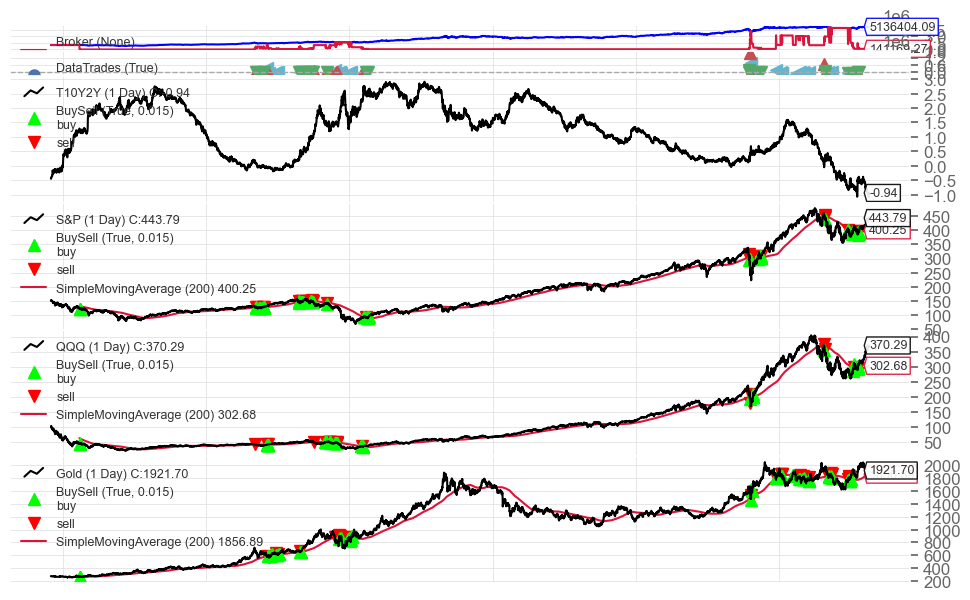

[[<Figure size 1000x600 with 6 Axes>]]

In [23]:
cerebro.plot(volume=False,iplot=False)

## Plotting Stats

                           Strategy
-------------------------  ----------
Start Period               2000-08-30
End Period                 2023-07-06
Risk-Free Rate             0.0%
Time in Market             93.0%

Cumulative Return          413.64%
CAGR﹪                     7.42%

Sharpe                     0.66
Prob. Sharpe Ratio         99.91%
Smart Sharpe               0.65
Sortino                    0.92
Smart Sortino              0.91
Sortino/√2                 0.65
Smart Sortino/√2           0.64
Omega                      1.13

Max Drawdown               -25.84%
Longest DD Days            1600
Volatility (ann.)          11.95%
Calmar                     0.29
Skew                       -0.48
Kurtosis                   4.39

Expected Daily %           0.03%
Expected Monthly %         0.59%
Expected Yearly %          7.06%
Kelly Criterion            6.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.21%
Expected Shortfall (cVaR)  -1.21%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2001-07-03,2002-10-09,2003-10-21,840,-25.838557,-24.364377
2,2012-10-05,2013-06-27,2017-02-21,1600,-22.198562,-19.883925
3,2020-02-20,2020-04-01,2020-07-20,151,-14.107131,-12.487213
4,2006-05-12,2006-06-14,2007-07-06,420,-13.973152,-13.464607
5,2011-09-06,2011-12-29,2012-02-23,170,-12.561683,-11.678615


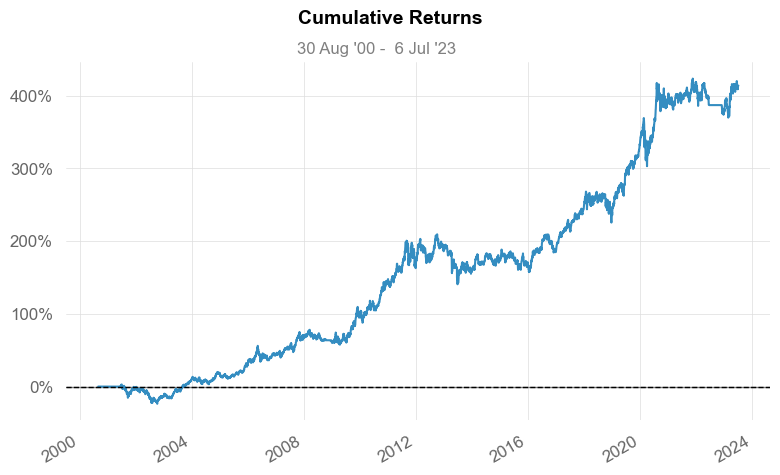

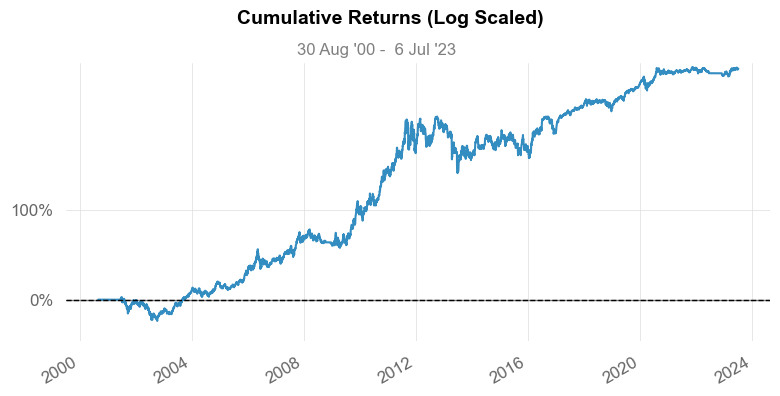

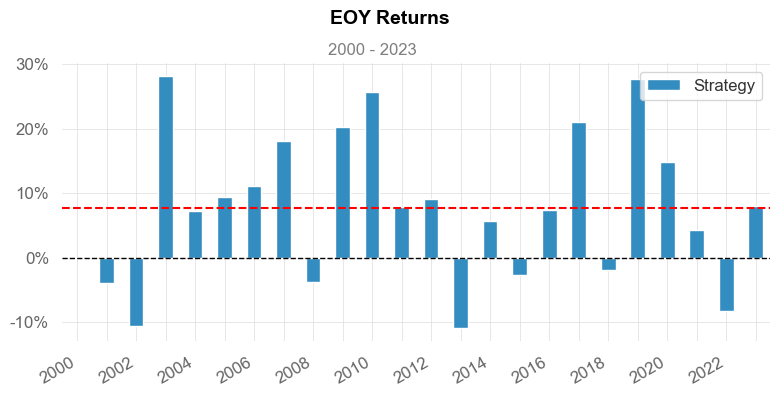

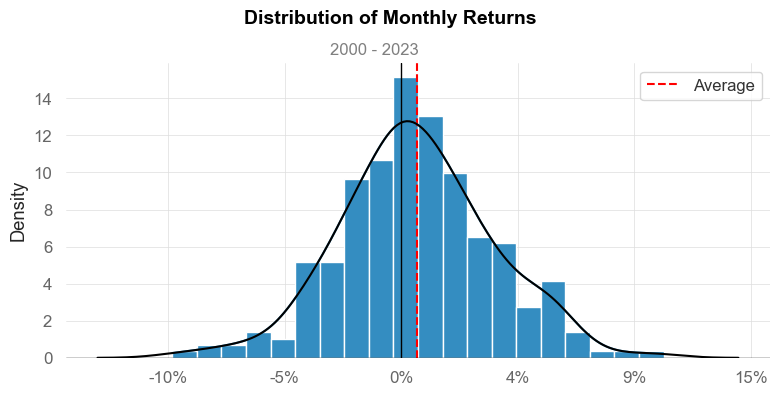

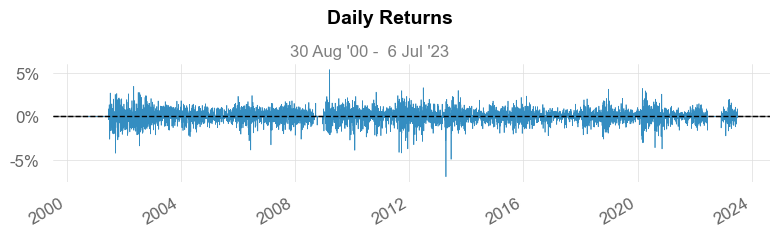

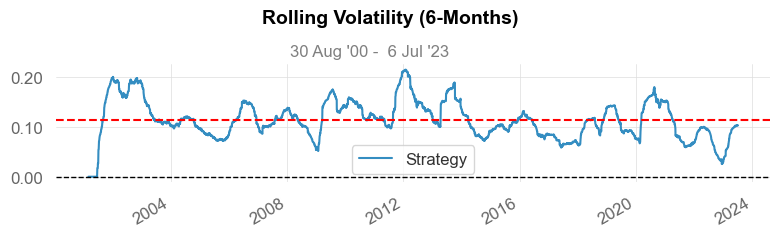

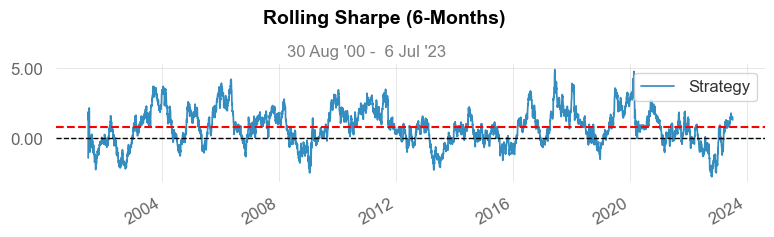

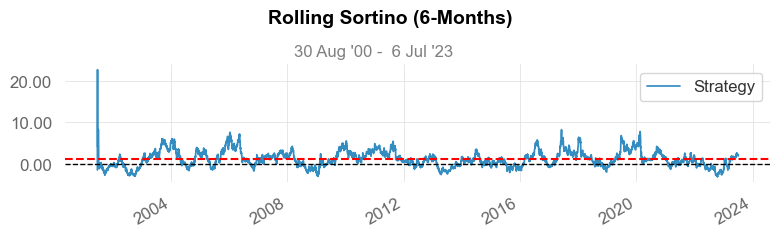

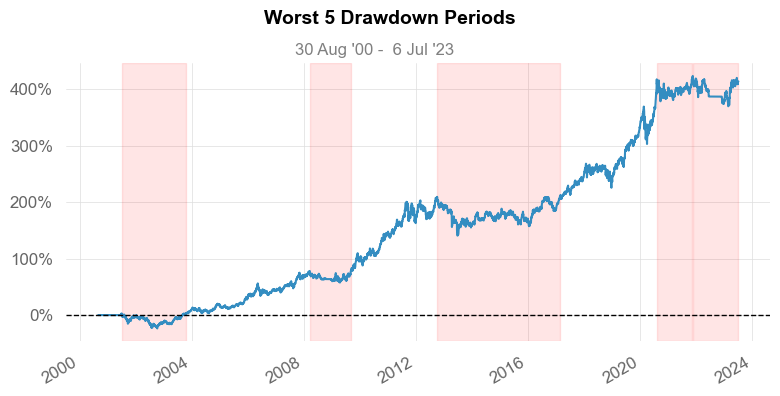

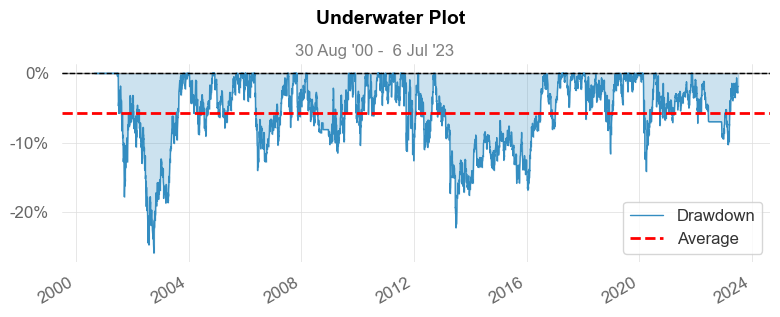

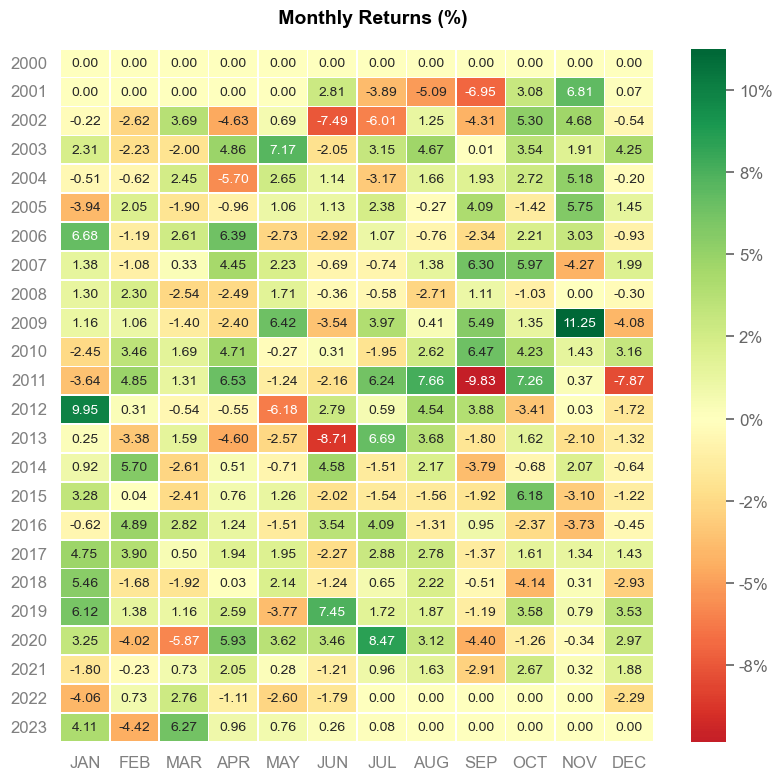

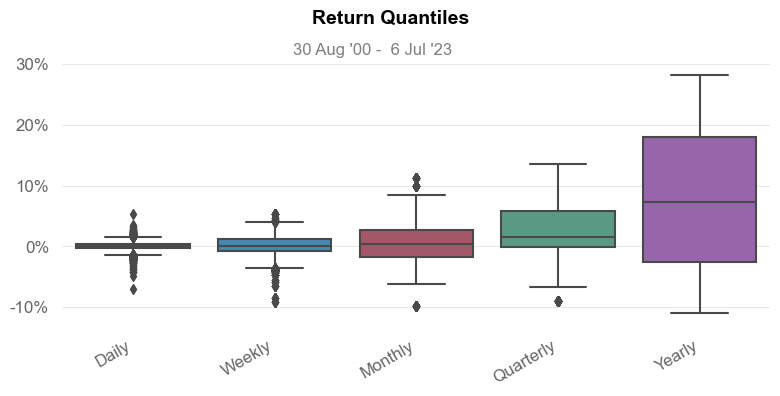

In [24]:
import quantstats as qs
strat=results[-1]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.full(returns)